In [709]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

unidf=pd.read_csv(r"C:\Users\hajar\Time-Series-Crime-Forecasting-Minneapolis-3\data\Univ_Date.csv")

## ARIMA
1. Split the data into a train and test using time-based splitting
2. Check Assumptions and make corrections if needed
3. Select ARIMA Model
4. Select Best ARIMA Model
4. Interpret

### Split Data

Partition the data set into 4 parts corresponding to 2019-2024. then create nested training sets.

In [710]:
#Validation Set

#sort Data
unidf=unidf.set_index('Date')
unidf=unidf.sort_index()

unidf.reset_index()
unidf['date']=unidf.index
unidf['date'] = pd.to_datetime(unidf['date'], format='%Y-%m-%d')
unidf

,Crime_Count,date
Date,,
2019-01-01,88,2019-01-01
2019-01-02,102,2019-01-02
2019-01-03,133,2019-01-03
2019-01-04,95,2019-01-04
2019-01-05,83,2019-01-05
...,...,...
2025-03-06,89,2025-03-06
2025-03-07,89,2025-03-07
2025-03-08,70,2025-03-08


In [711]:
#Divide Data into 4 pairs of train and test sets

#Partition data by year
df19= unidf[unidf['date'].dt.year == 2019].copy()
df20= unidf[unidf['date'].dt.year == 2020].copy()
df21= unidf[unidf['date'].dt.year == 2021].copy()
df22= unidf[unidf['date'].dt.year == 2022].copy()
df23= unidf[unidf['date'].dt.year == 2023].copy()
df24= unidf[unidf['date'].dt.year == 2024].copy()

#create 2025 df for assessing model
df25=unidf[unidf['date'].dt.year == 2025].copy()

#Drop extra column
df19= df19.drop(columns=['date'])
df20= df20.drop(columns=['date'])
df21= df21.drop(columns=['date'])
df22= df22.drop(columns=['date'])
df23= df23.drop(columns=['date'])
df24= df24.drop(columns=['date'])
df25=df25.drop(columns=['date'])

#Create 4 pairs of train/test sets

train1=pd.concat([df19, df20])
test1=df21

train2=pd.concat([train1, df21])
test2=df22

train3=pd.concat([train2, df22])
test3=df23

train4=pd.concat([train3, df23])
test4=df24

## STEP 1: Set 1 2019-2021
### Check Stationarity


Text(0, 0.5, '\nNumber of Reported Crimes\n')

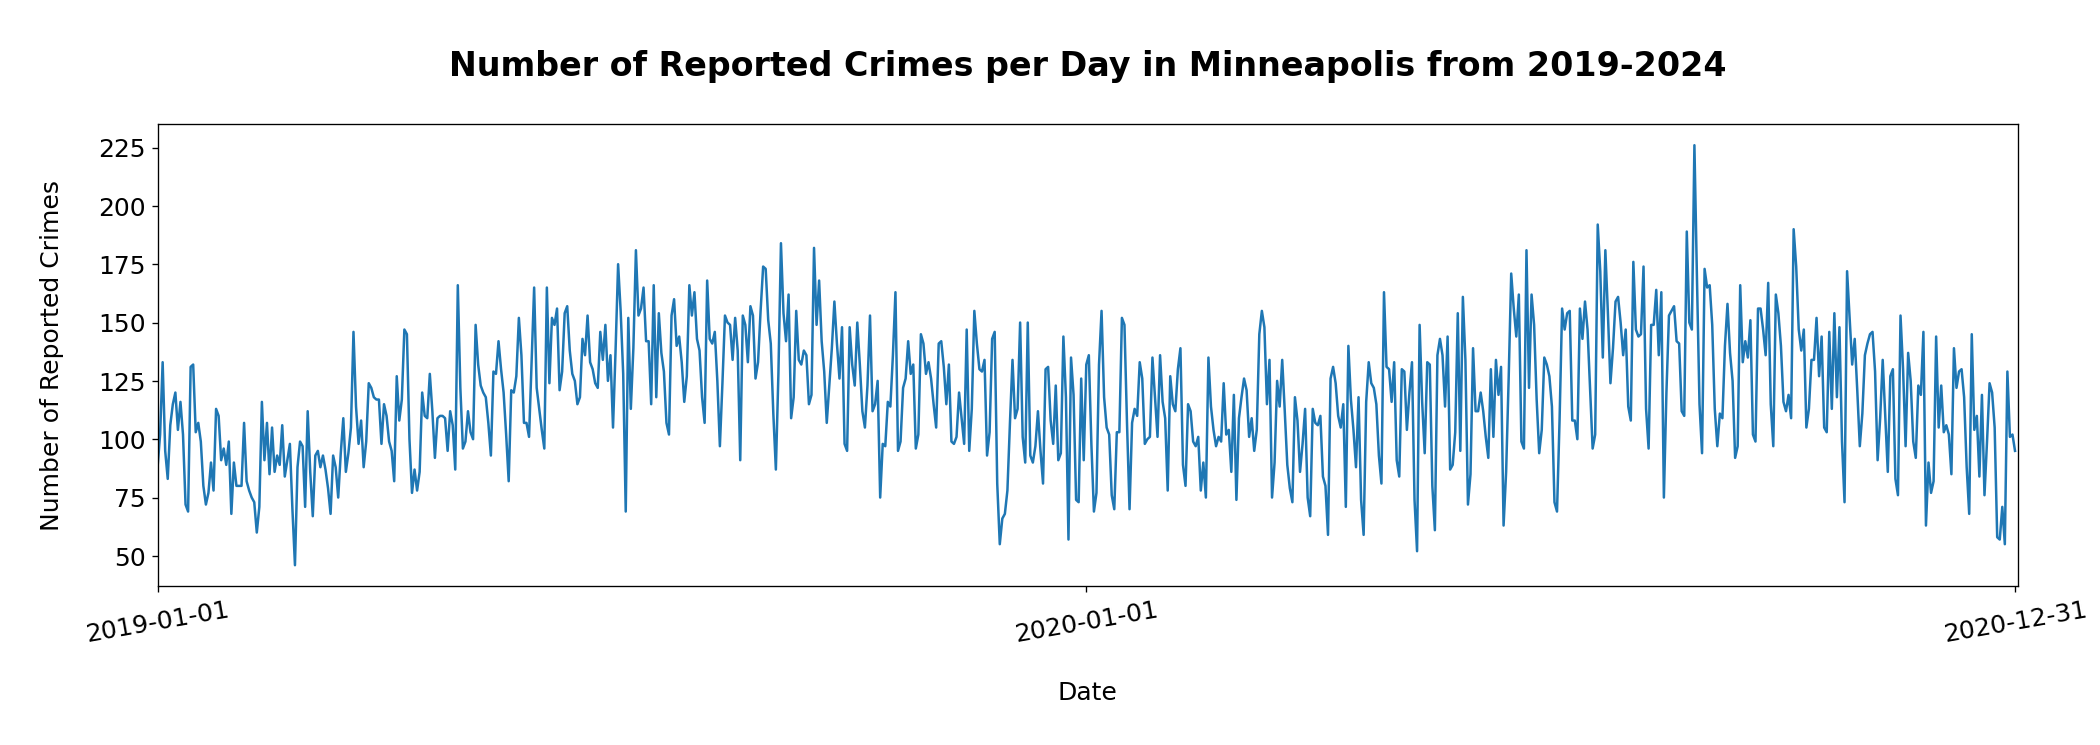

In [712]:
#Look at plot
fig, ax=plt.subplots(figsize=(20, 5))
plt.plot(train1.Crime_Count); 
plt.xticks(rotation=10, fontsize=15)

years = mdates.YearLocator()  
ax.xaxis.set_major_locator(years)

ax.set_xlim('2019-01-01', '2024-12-31')
ax.set_title("\nNumber of Reported Crimes per Day in Minneapolis from 2019-2024\n",weight='bold',fontdict={'fontsize':20})
ax.set_xlabel("\nDate\n",fontdict={'fontsize':15})
ax.set_ylabel("\nNumber of Reported Crimes\n",fontdict={'fontsize':15})



In [713]:
#ADF Test
from statsmodels.tsa.stattools import adfuller,kpss
adfuller(train1) #Non-Stationary

(-1.5447958387885525,
 0.5112466837476183,
 20,
 710,
 {'1%': -3.439593802573824,
  '5%': -2.865619356068967,
  '10%': -2.568942332870462},
 6188.7623278914525)

In [714]:
#KPSS Test


### 1st Differencing

In [715]:
train1d1= train1
train1d1['Crime_Count']=train1.Crime_Count.diff().dropna()
train1d1

,Crime_Count
Date,
2019-01-01,NaN
2019-01-02,14.0
2019-01-03,31.0
2019-01-04,-38.0
2019-01-05,-12.0
...,...
2020-12-27,-16.0
2020-12-28,74.0
2020-12-29,-28.0


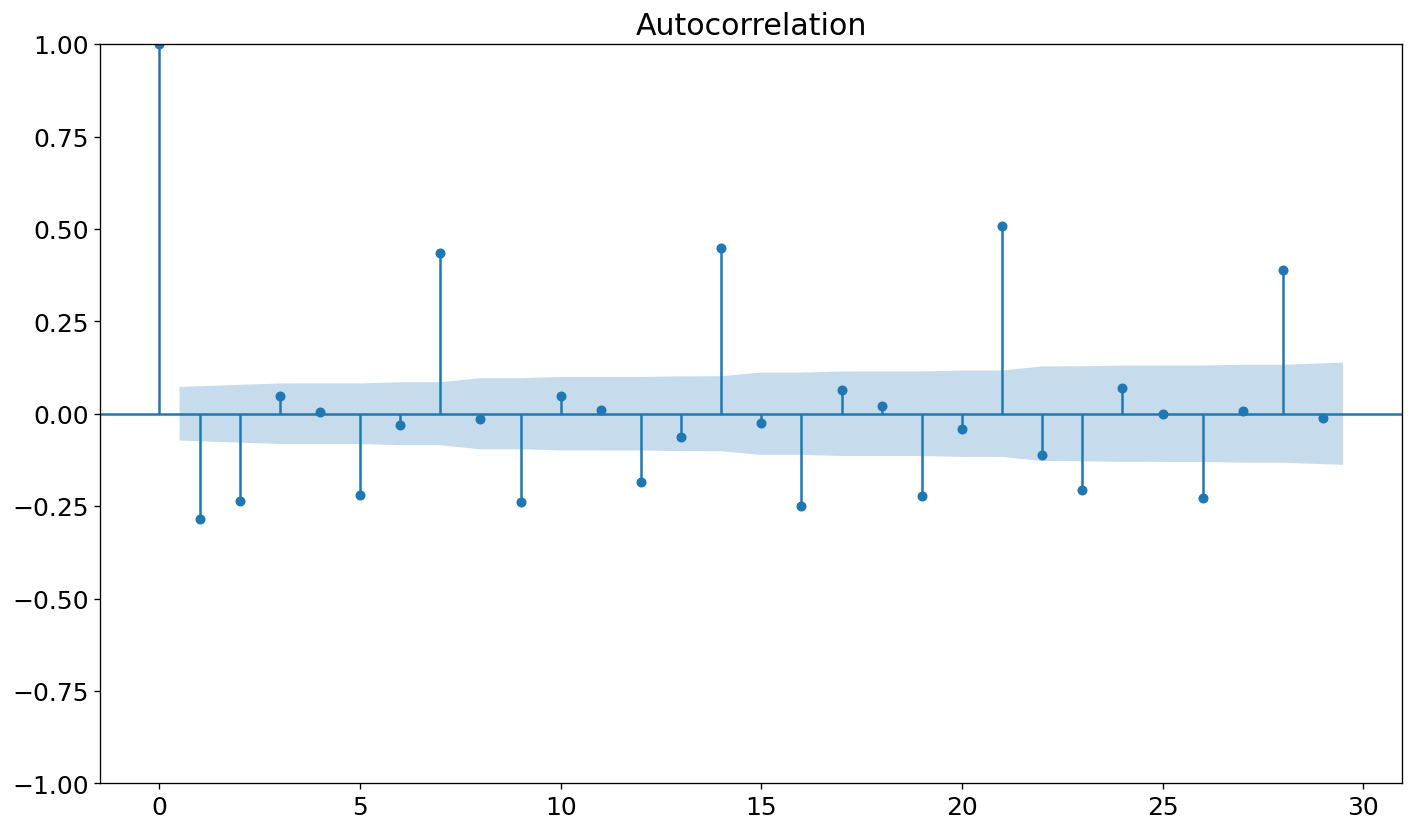

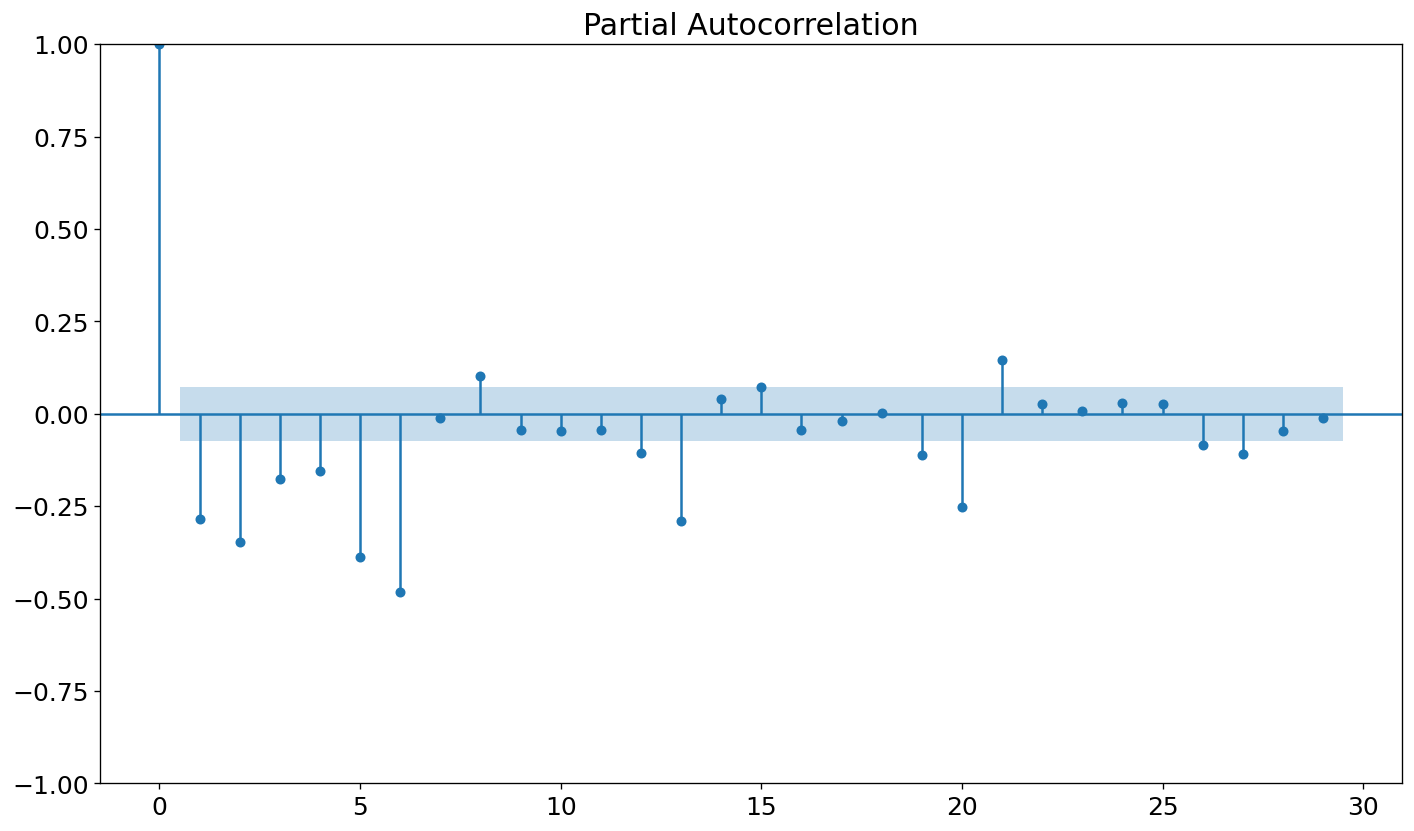

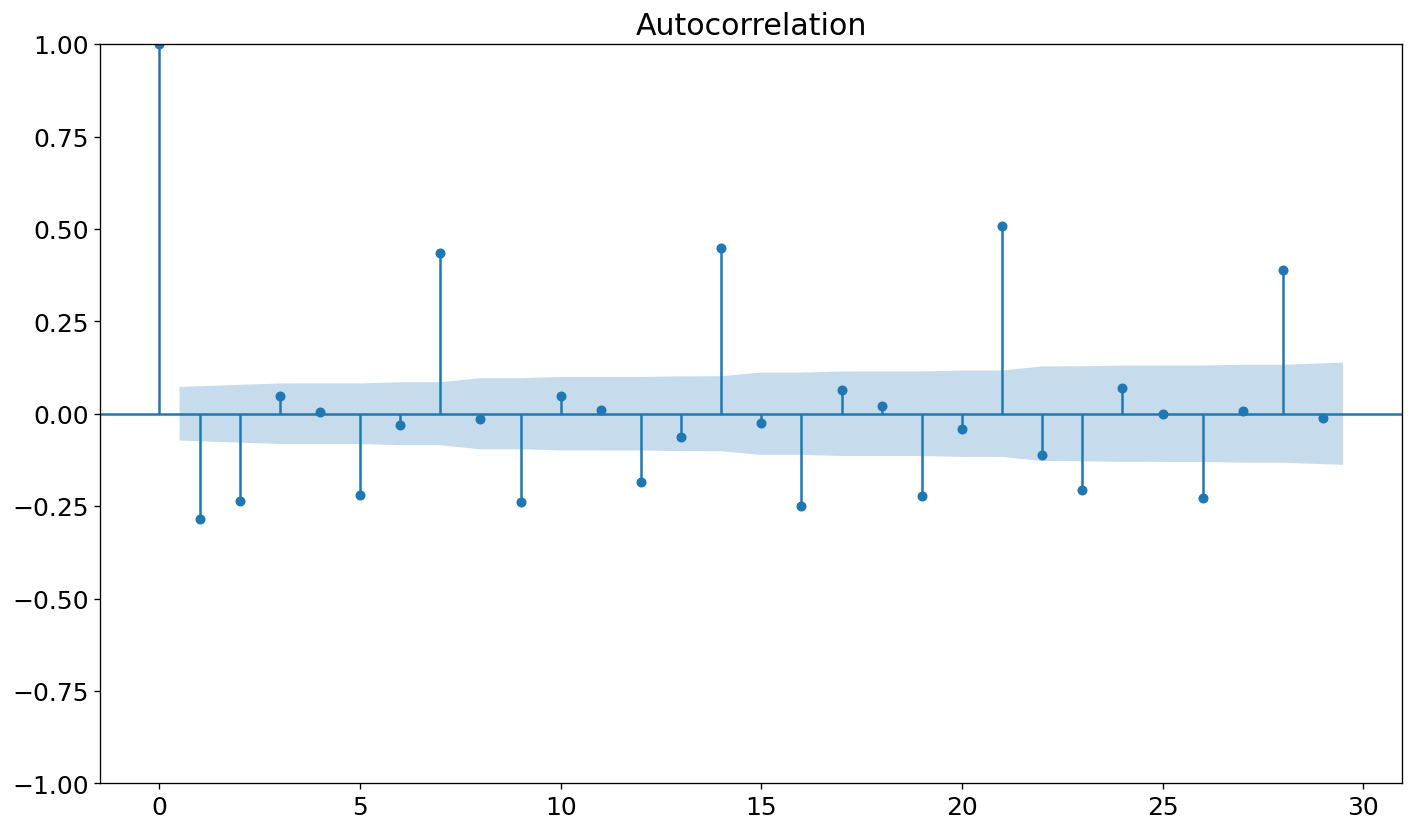

In [716]:
plot_pacf(train1.Crime_Count.dropna())
plot_acf(train1.Crime_Count.dropna())

Text(0, 0.5, '\nNumber of Reported Crimes\n')

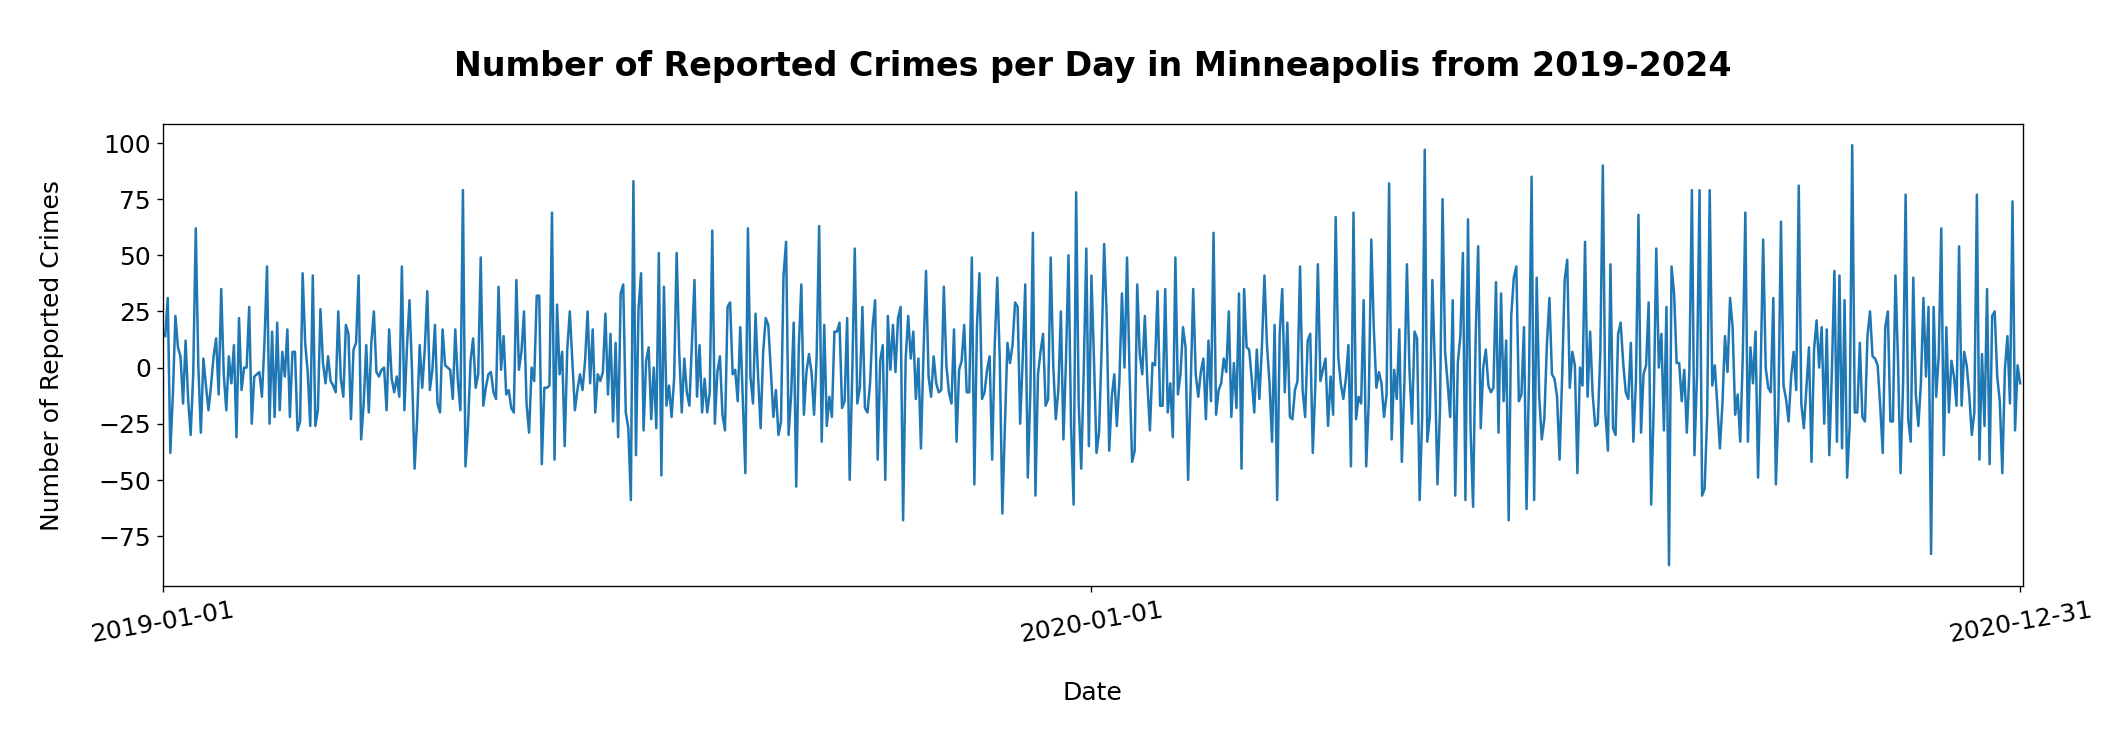

In [717]:
# Trying Differencing of 1
plt.close()
fig, ax=plt.subplots(figsize=(20, 5))
plt.plot(train1d1.Crime_Count); 
plt.xticks(rotation=10, fontsize=15)

years = mdates.YearLocator()  
ax.xaxis.set_major_locator(years)

ax.set_xlim('2019-01-01', '2024-12-31')
ax.set_title("\nNumber of Reported Crimes per Day in Minneapolis from 2019-2024\n",weight='bold',fontdict={'fontsize':20})
ax.set_xlabel("\nDate\n",fontdict={'fontsize':15})
ax.set_ylabel("\nNumber of Reported Crimes\n",fontdict={'fontsize':15})

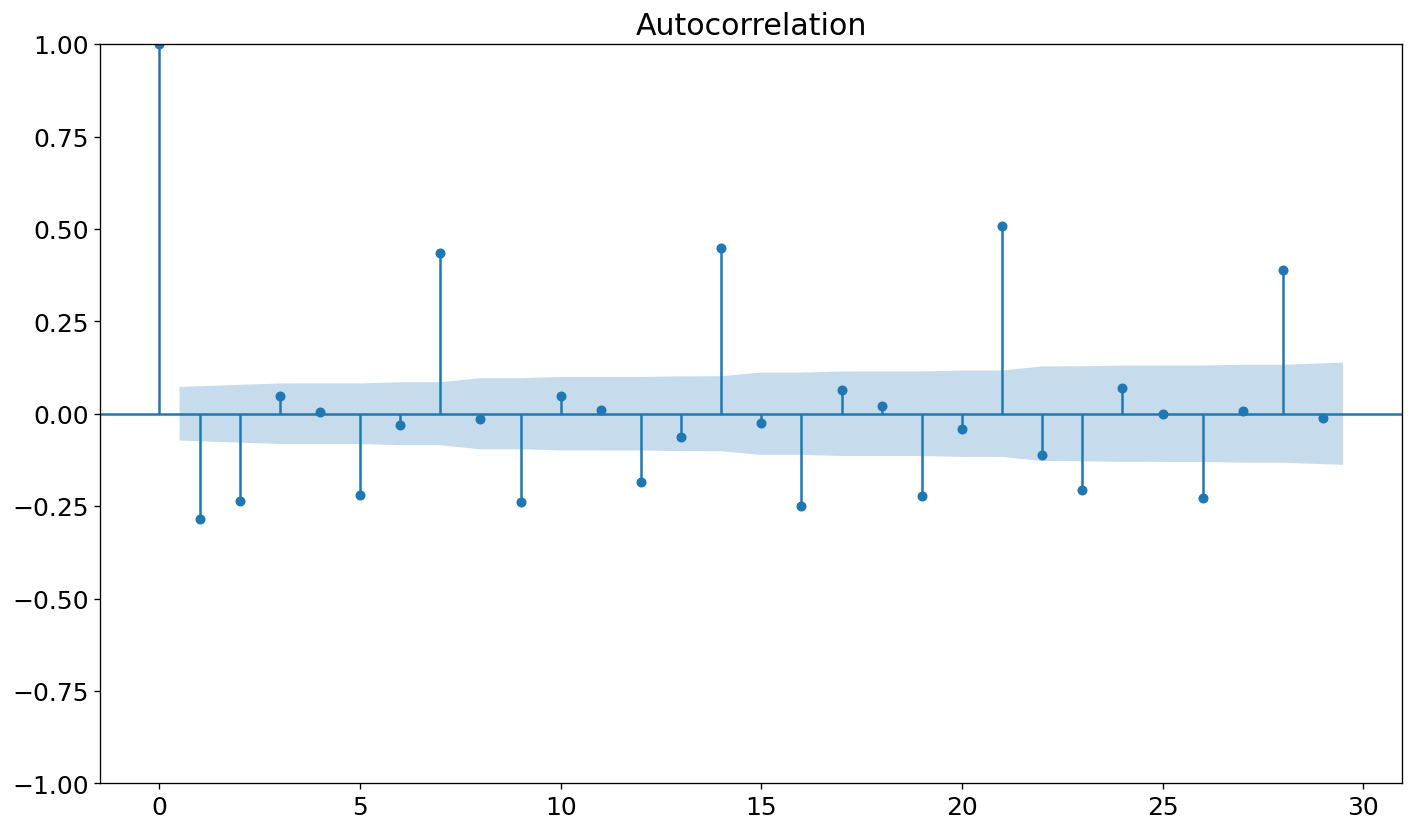

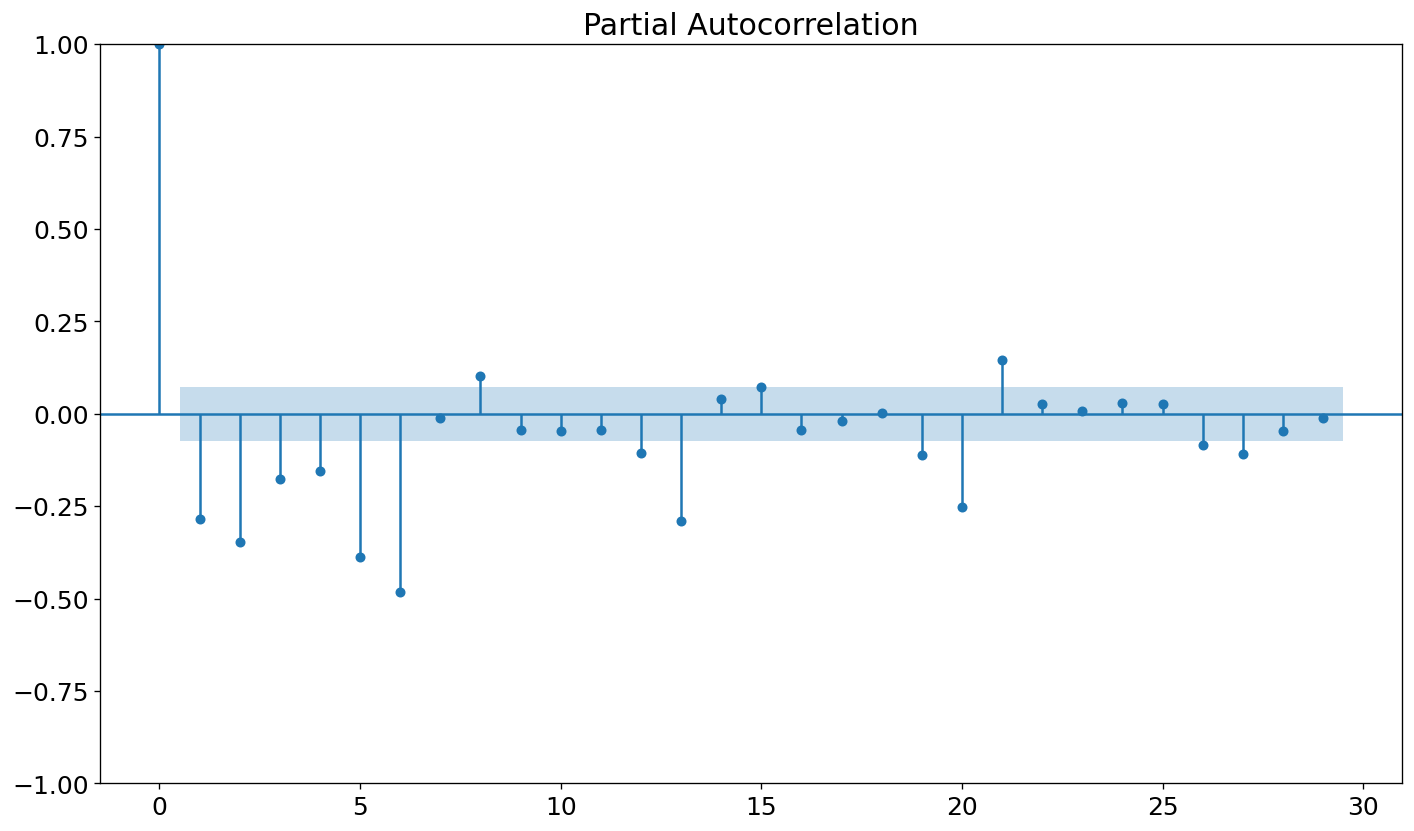

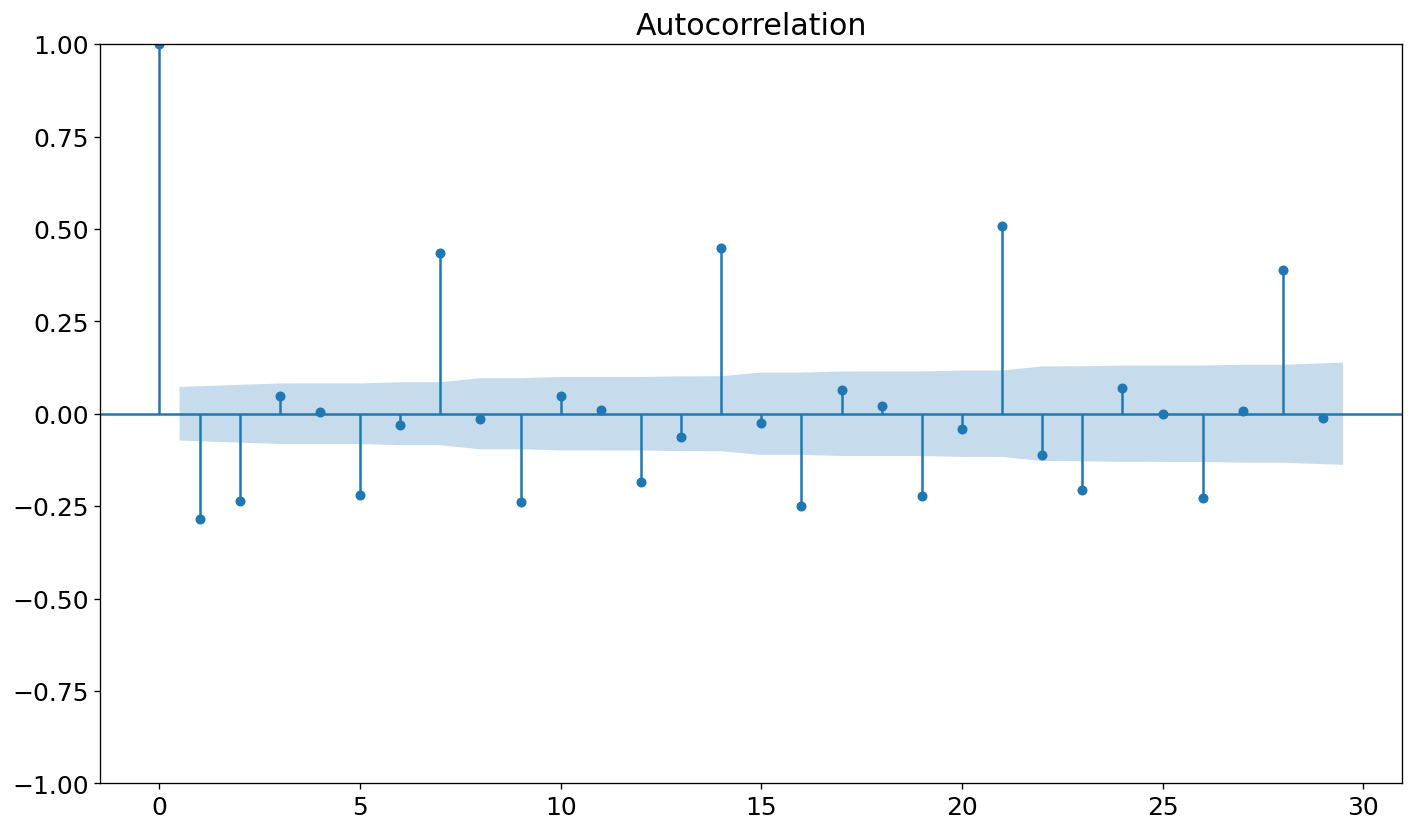

In [718]:
plot_pacf(train1d1.Crime_Count.dropna())
plot_acf(train1d1.Crime_Count.dropna())

In [719]:
#ADF
adfuller(train1d1.dropna()) #Non-Stationary

(-9.142064228280377,
 2.8318121713289358e-15,
 20,
 709,
 {'1%': -3.439606888036868,
  '5%': -2.865625121924057,
  '10%': -2.5689454046801052},
 6166.770428084819)

In [720]:
#KPSS

### 2nd Differencing

In [721]:
train1d2= train1d1
train1d2['Crime_Count']=train1d1.Crime_Count.diff().dropna()
train1d2

,Crime_Count
Date,
2019-01-01,NaN
2019-01-02,NaN
2019-01-03,17.0
2019-01-04,-69.0
2019-01-05,26.0
...,...
2020-12-27,-30.0
2020-12-28,90.0
2020-12-29,-102.0


Text(0, 0.5, '\nNumber of Reported Crimes\n')

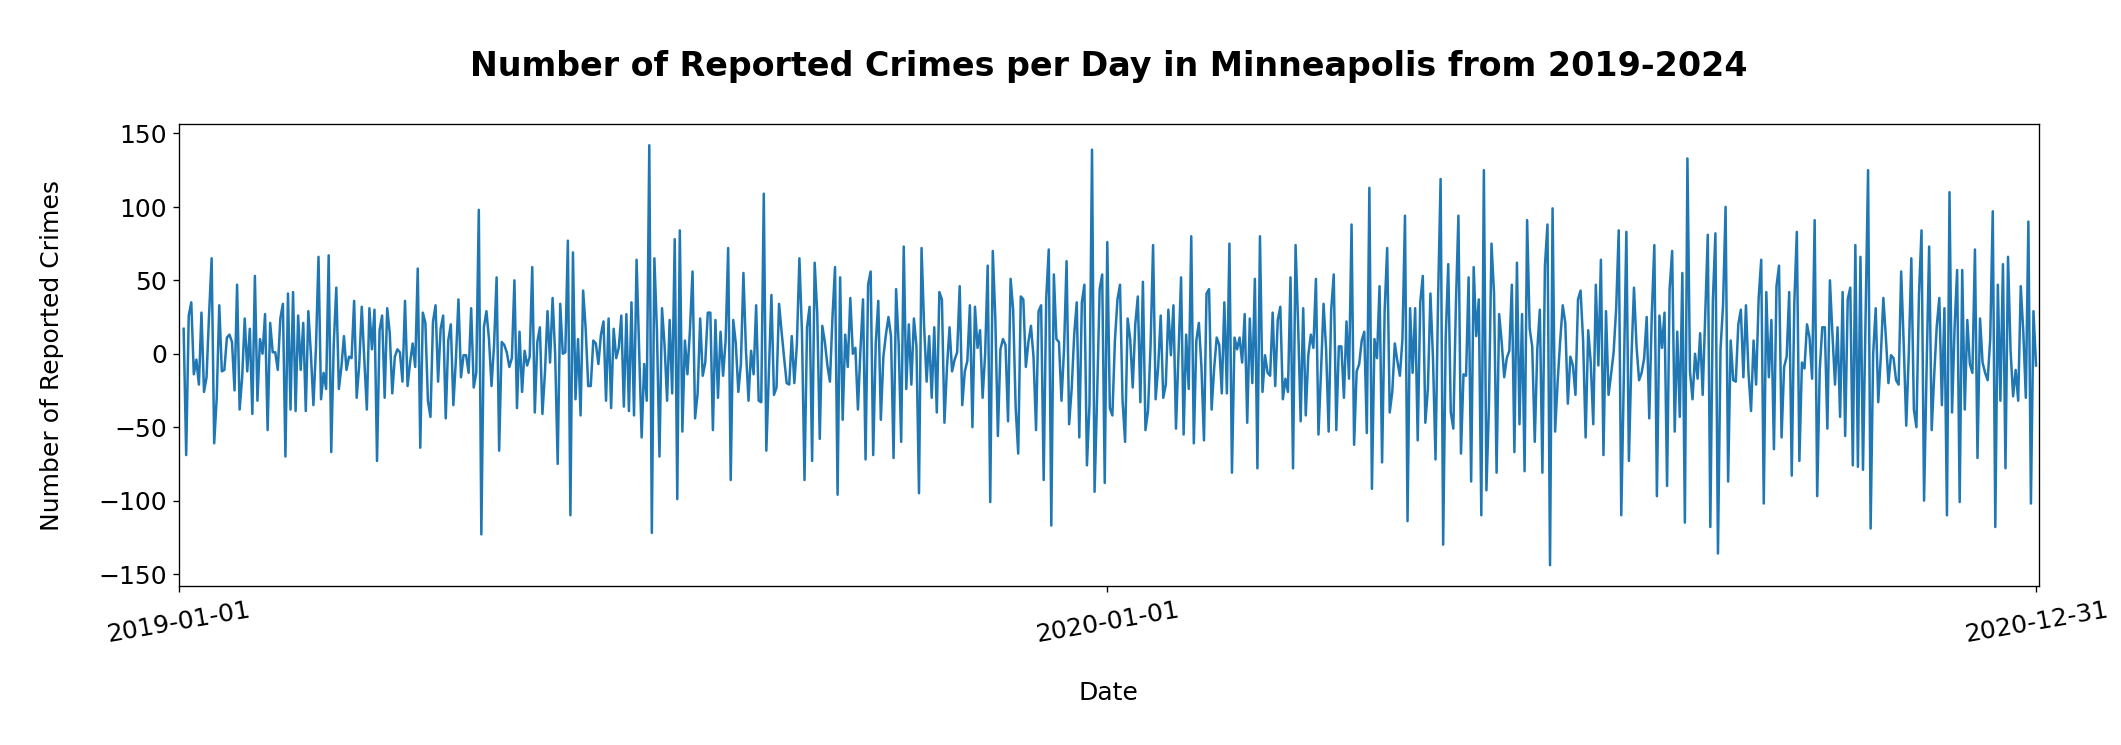

In [722]:
# Trying Differencing of 2
plt.close()
fig, ax=plt.subplots(figsize=(20, 5))
plt.plot(train1d2.Crime_Count); 
plt.xticks(rotation=10, fontsize=15)

years = mdates.YearLocator()  
ax.xaxis.set_major_locator(years)

ax.set_xlim('2019-01-01', '2024-12-31')
ax.set_title("\nNumber of Reported Crimes per Day in Minneapolis from 2019-2024\n",weight='bold',fontdict={'fontsize':20})
ax.set_xlabel("\nDate\n",fontdict={'fontsize':15})
ax.set_ylabel("\nNumber of Reported Crimes\n",fontdict={'fontsize':15})

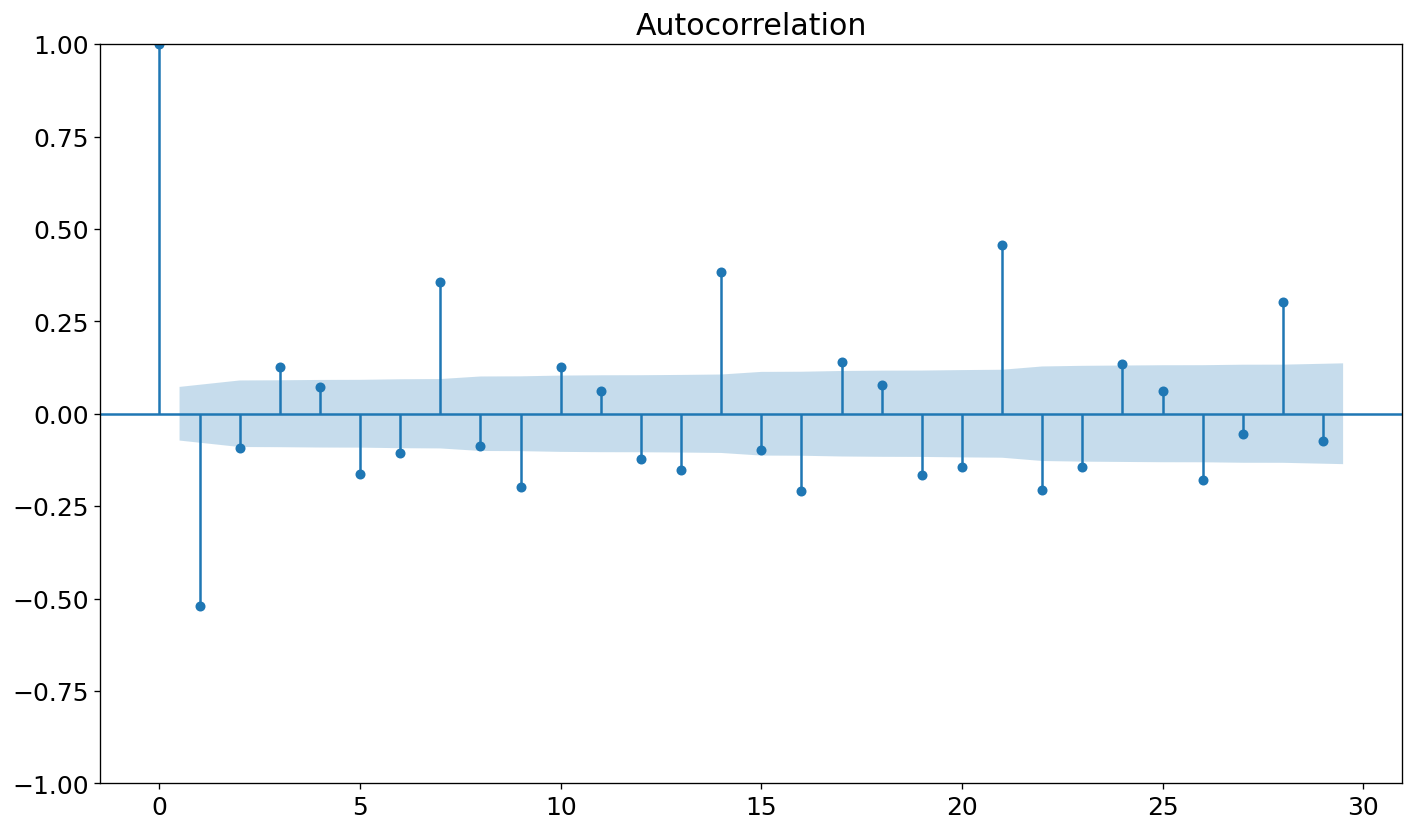

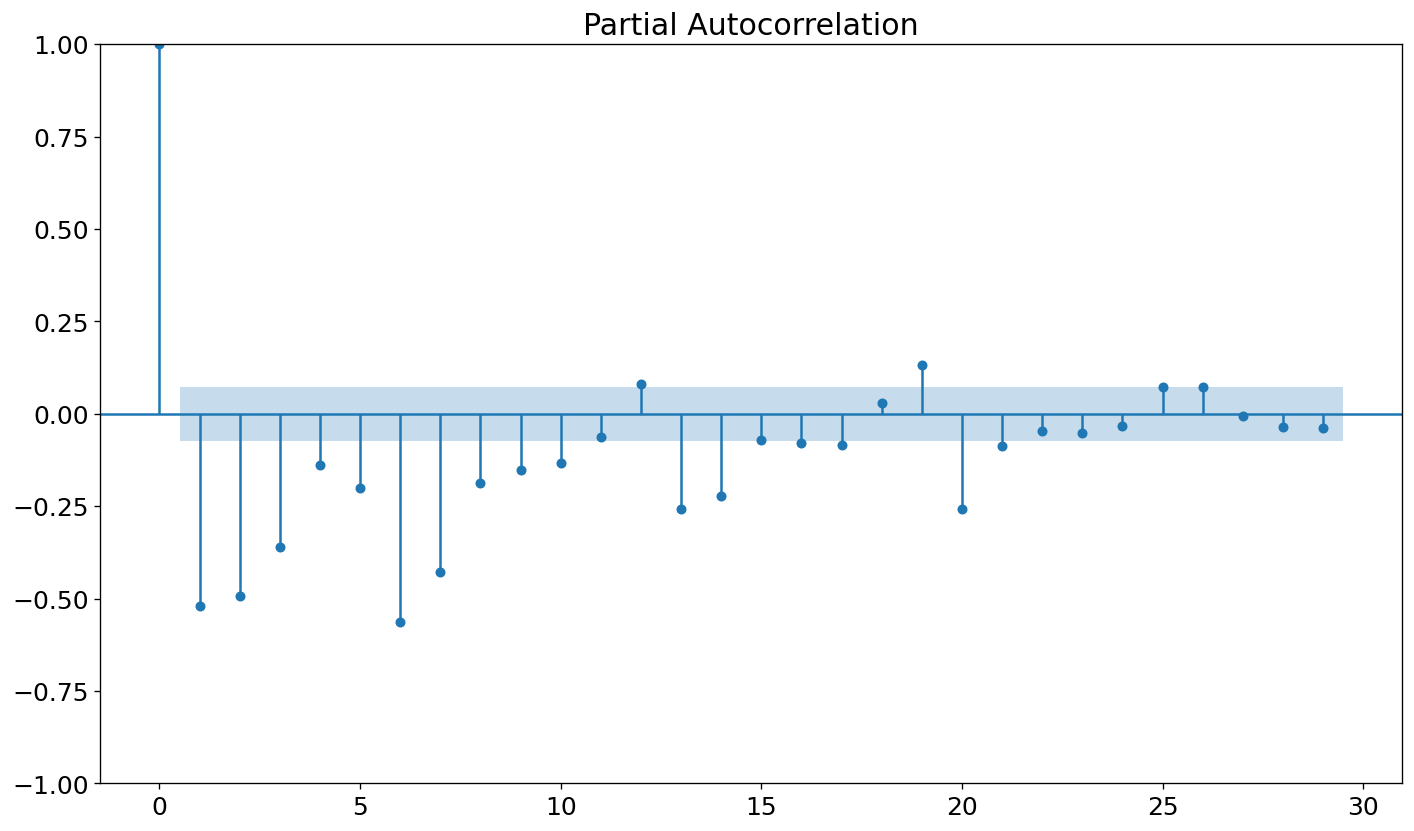

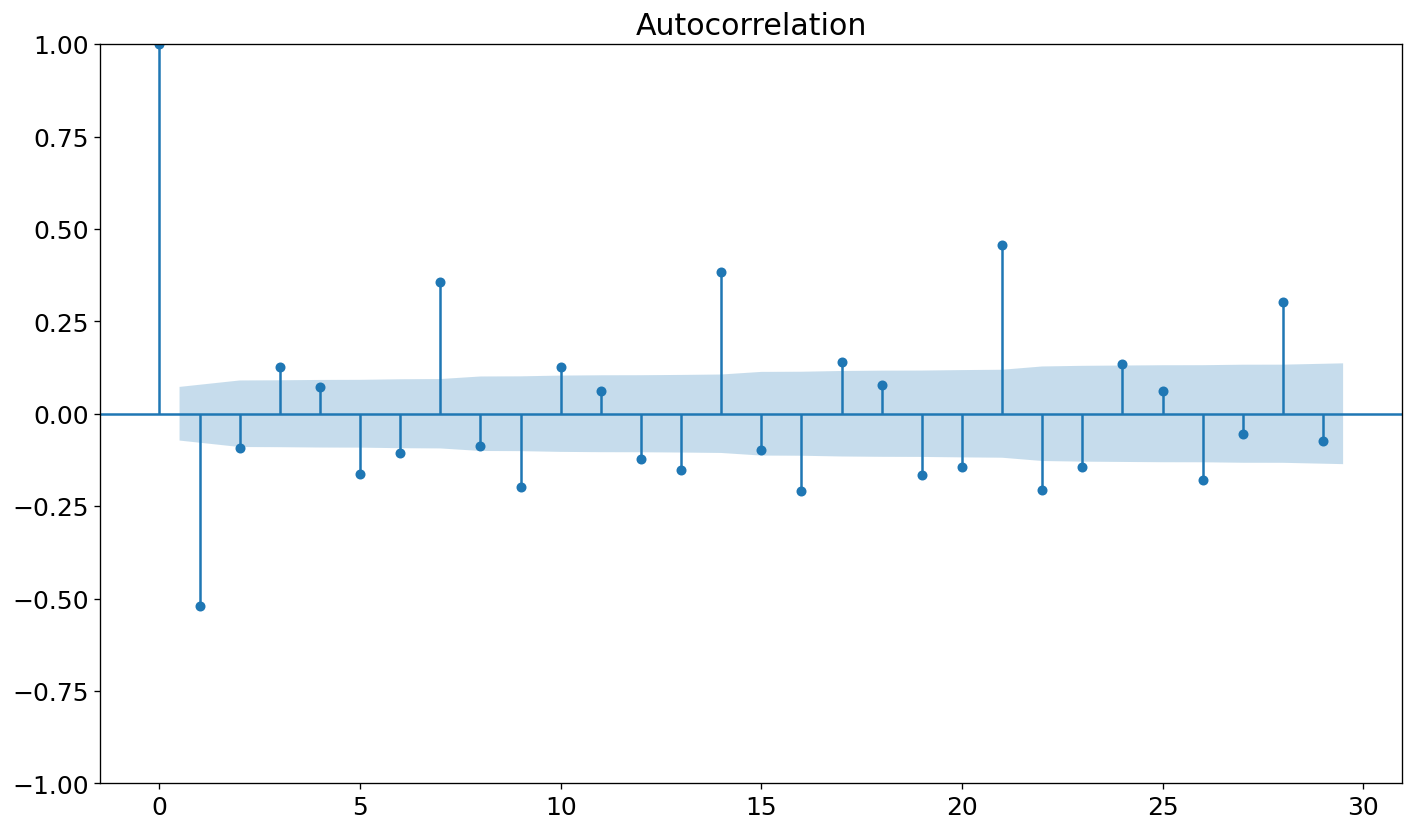

In [723]:
plot_pacf(train1d2.Crime_Count.dropna())
plot_acf(train1d2.Crime_Count.dropna())

In [724]:
#ADF
adfuller(train1d2.dropna()) #Non-Stationary

(-13.52575585828878,
 2.680620770272072e-25,
 20,
 708,
 {'1%': -3.439620010600208,
  '5%': -2.8656309041017756,
  '10%': -2.5689484851894413},
 6224.4025393261945)

### 3nd Differencing

In [725]:
train1d3= train1d2
train1d3['Crime_Count']=train1d2.Crime_Count.diff().dropna()
train1d3

,Crime_Count
Date,
2019-01-01,NaN
2019-01-02,NaN
2019-01-03,NaN
2019-01-04,-86.0
2019-01-05,95.0
...,...
2020-12-27,-45.0
2020-12-28,120.0
2020-12-29,-192.0


Text(0, 0.5, '\nNumber of Reported Crimes\n')

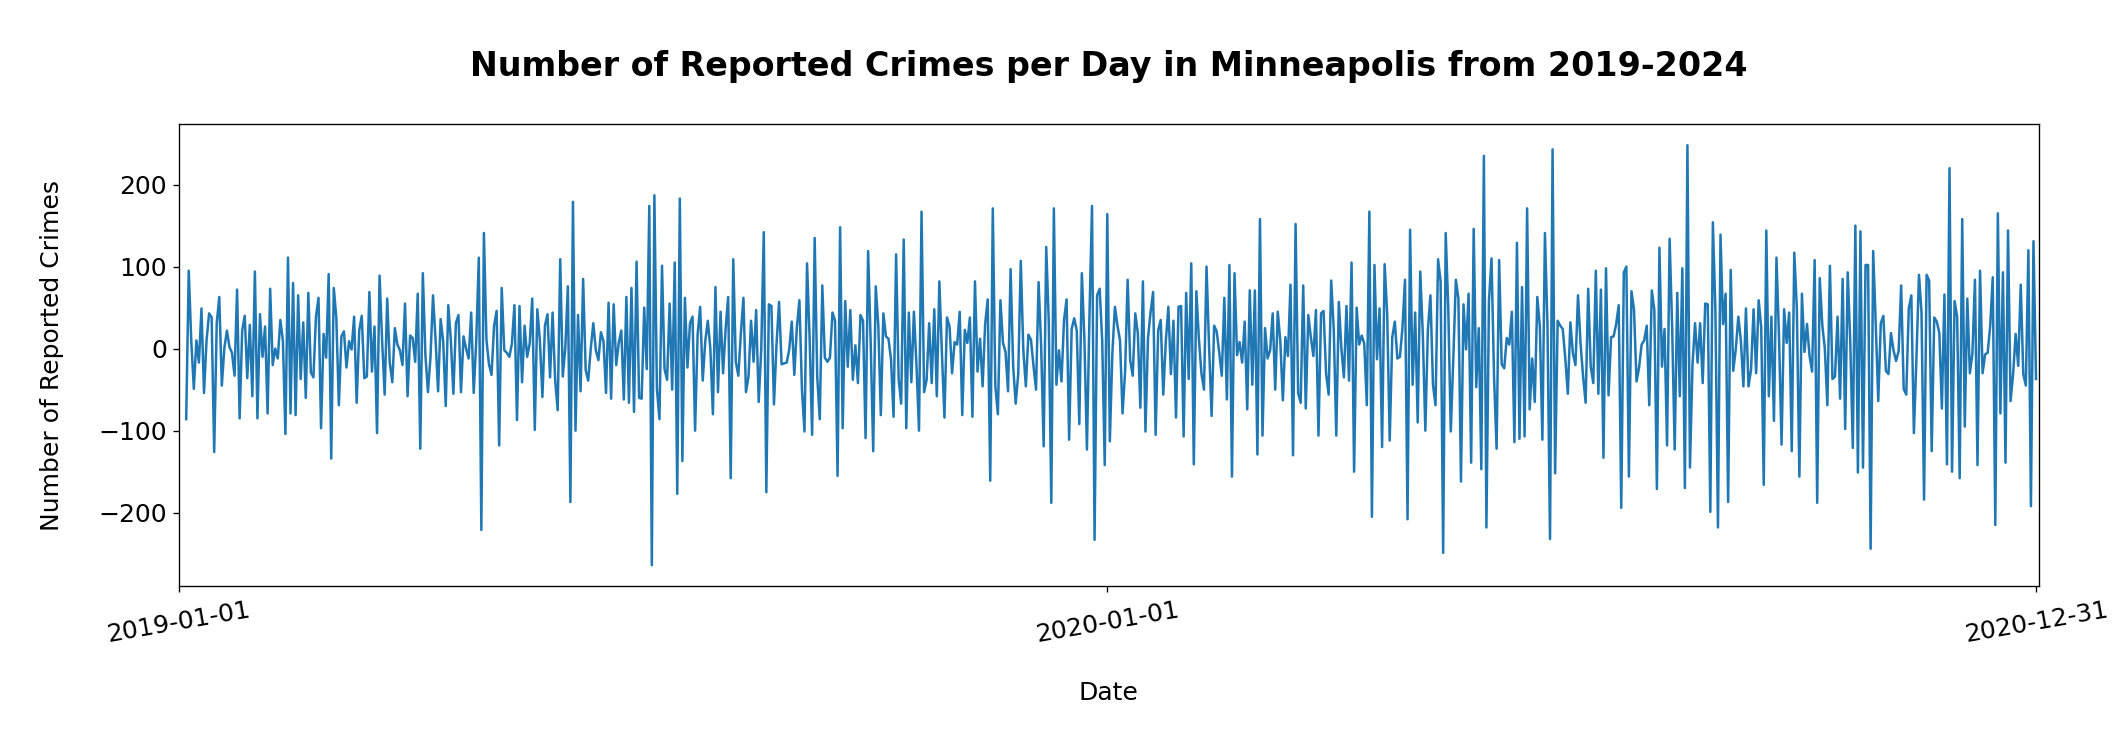

In [726]:
# Trying Differencing of 3
plt.close()
fig, ax=plt.subplots(figsize=(20, 5))
plt.plot(train1d3.Crime_Count); 
plt.xticks(rotation=10, fontsize=15)

years = mdates.YearLocator()  
ax.xaxis.set_major_locator(years)

ax.set_xlim('2019-01-01', '2024-12-31')
ax.set_title("\nNumber of Reported Crimes per Day in Minneapolis from 2019-2024\n",weight='bold',fontdict={'fontsize':20})
ax.set_xlabel("\nDate\n",fontdict={'fontsize':15})
ax.set_ylabel("\nNumber of Reported Crimes\n",fontdict={'fontsize':15})

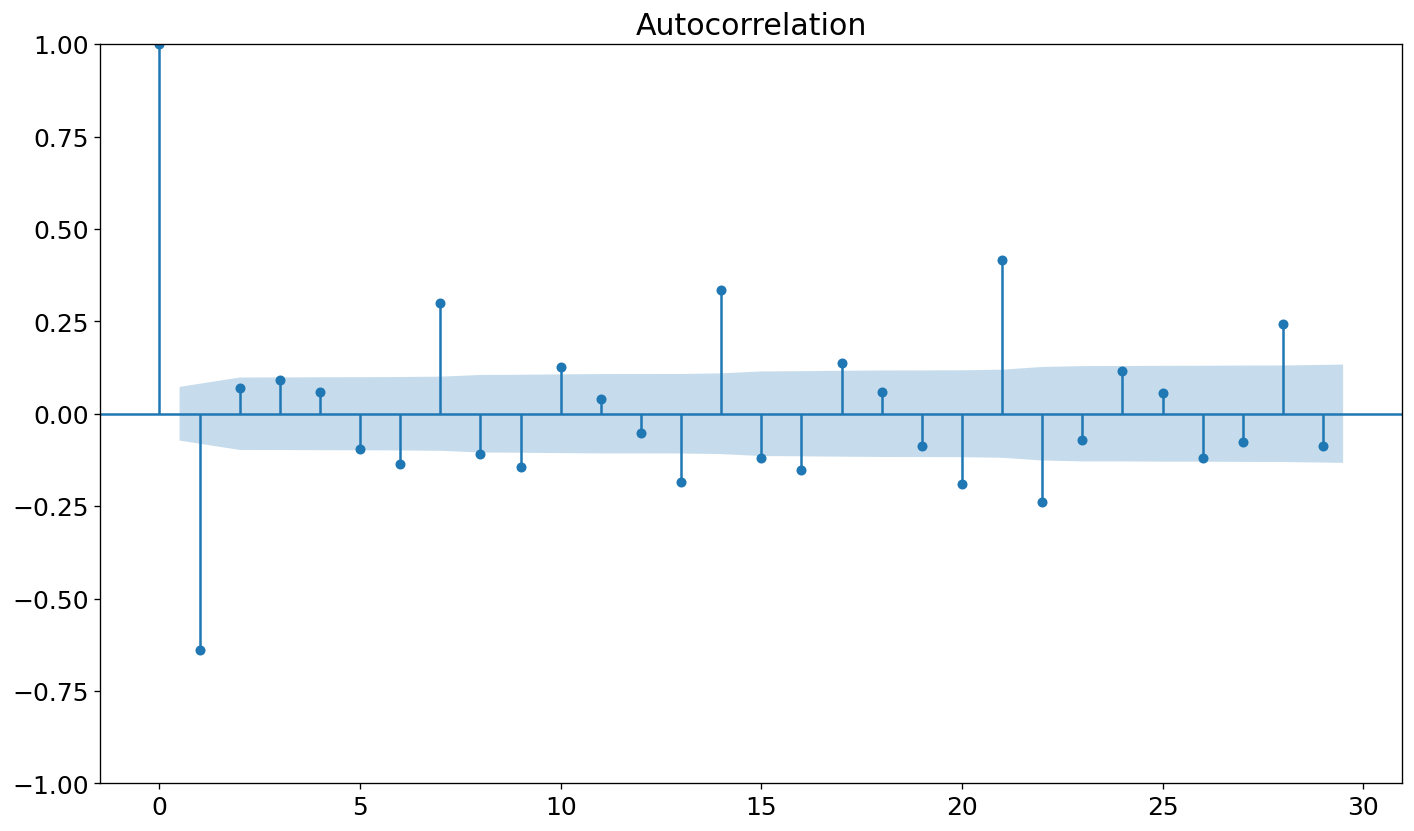

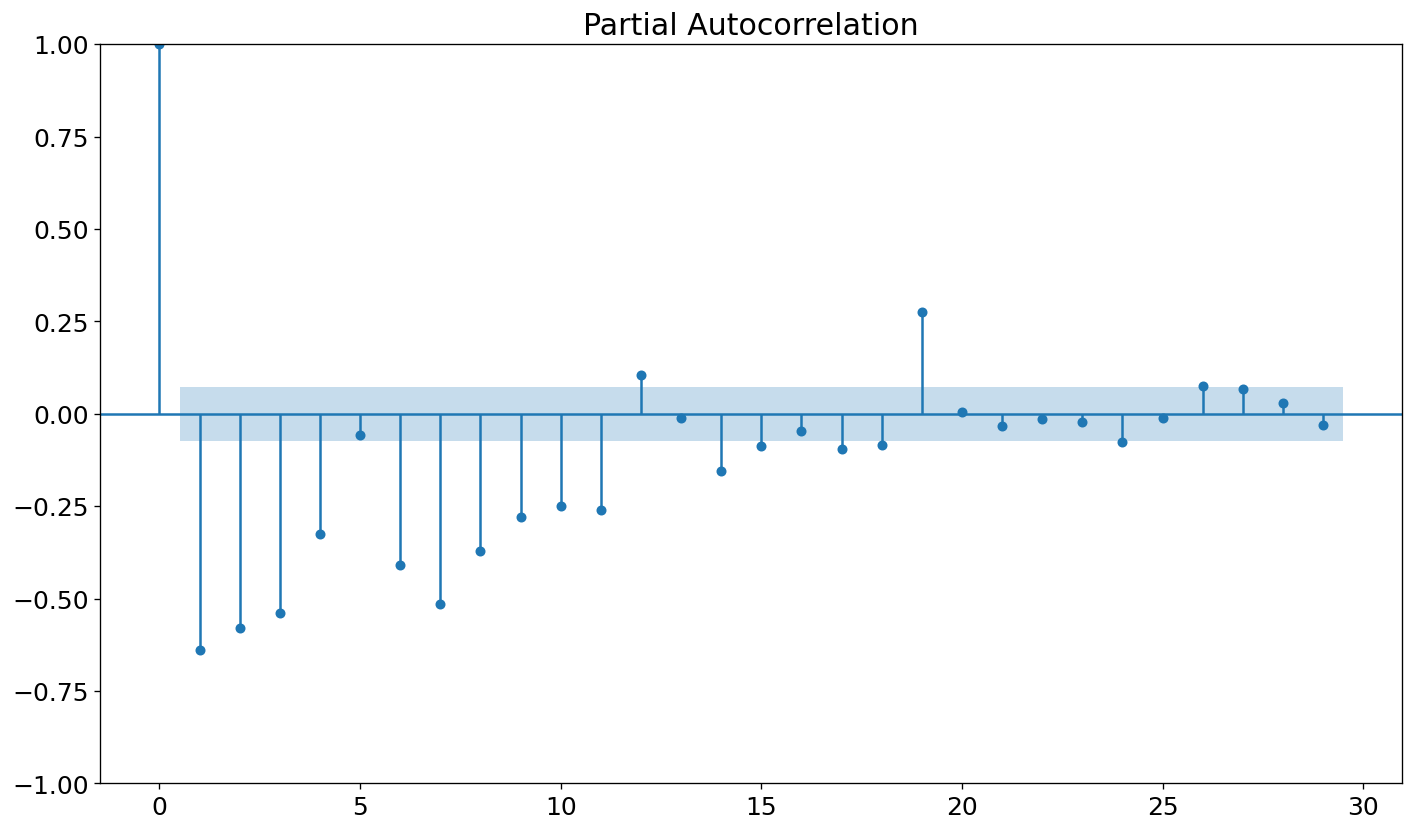

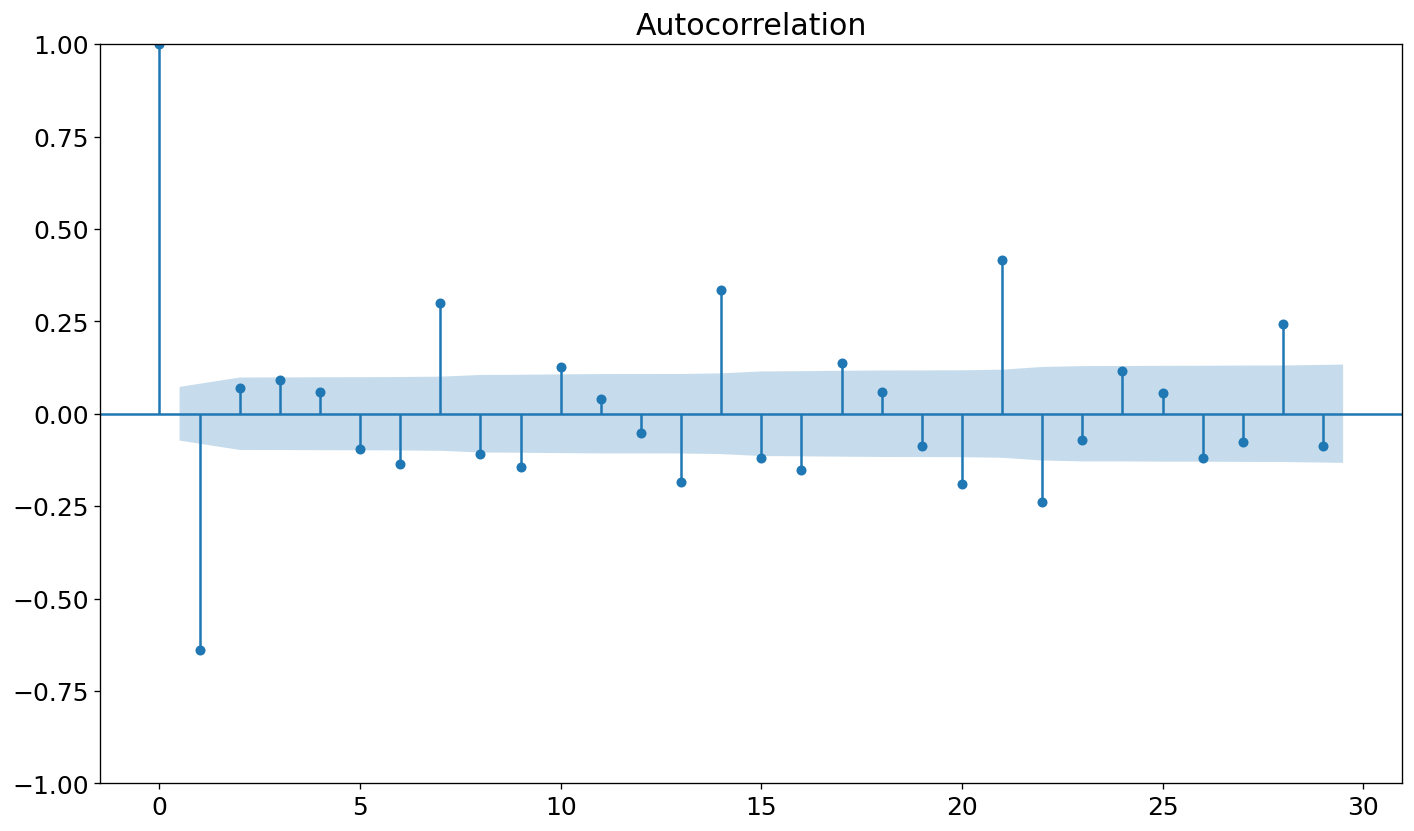

In [727]:
plot_pacf(train1d3.Crime_Count.dropna())
plot_acf(train1d3.Crime_Count.dropna())

### Differencing Didn't Work so we check for trends (seasonality year)

In [728]:
train1['date']=train1.index
train1['date'] = pd.to_datetime(train1['date'], format='%Y-%m-%d')
train1

,Crime_Count,date
Date,,
2019-01-01,NaN,2019-01-01
2019-01-02,NaN,2019-01-02
2019-01-03,NaN,2019-01-03
2019-01-04,-86.0,2019-01-04
2019-01-05,95.0,2019-01-05
...,...,...
2020-12-27,-45.0,2020-12-27
2020-12-28,120.0,2020-12-28
2020-12-29,-192.0,2020-12-29


In [729]:
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

train1['date']=train1.index
train1['date'] = pd.to_datetime(train1['date'], format='%Y-%m-%d')

# # # perform seasonal decomposition
# # result = seasonal_decompose(train1['date'], model='additive', period=12)

# # # plot the original data
# # plt.figure(figsize=(30, 8))
# # plt.subplot(411)
# # plt.plot(train1['date'], label='Original')
# # plt.legend(loc='best')
# # plt.xticks(rotation = 90)

# # # plot trend in data
# # #plt.subplot(412)
# # plt.plot(result.trend, label='Trend')
# # plt.legend(loc='best')
# # plt.xticks(rotation = 90)

# # # plot seasonality in data
# # #plt.subplot(413)
# # plt.plot(result.seasonal, label='Seasonal')
# # plt.legend(loc='best')
# # plt.xticks(rotation = 90)

# # # plot residual components
# # #plt.subplot(414)
# # #plt.plot(result.resid, label='Residual')
# # #plt.legend(loc='best')
# # #plt.xticks(rotation = 90)

# # # show plot
# # #plt.tight_layout()
# # #plt.show()

plt.rc('figure',figsize=(14,8))
plt.rc('font',size=15)

result = seasonal_decompose(train1,model='additive')
fig = result.plot()

TypeError: float() argument must be a string or a real number, not 'Timestamp'

### Determine p and q

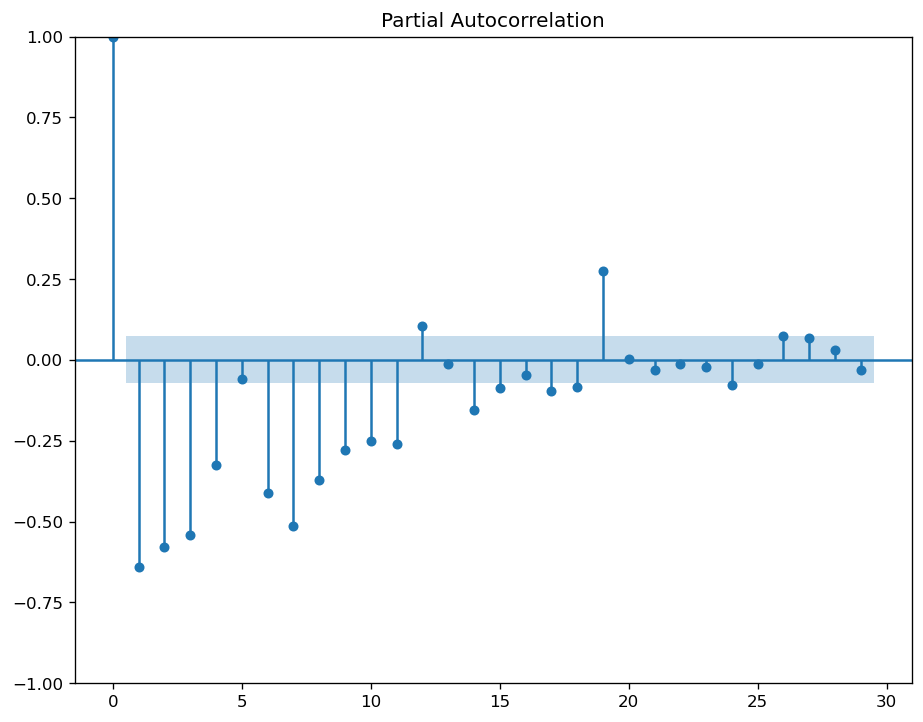

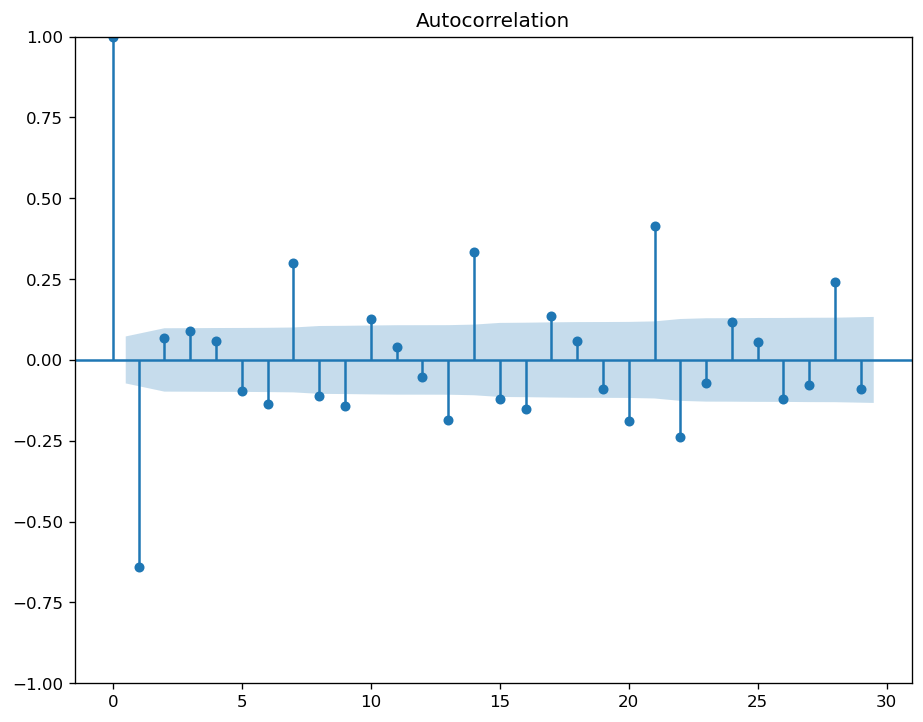

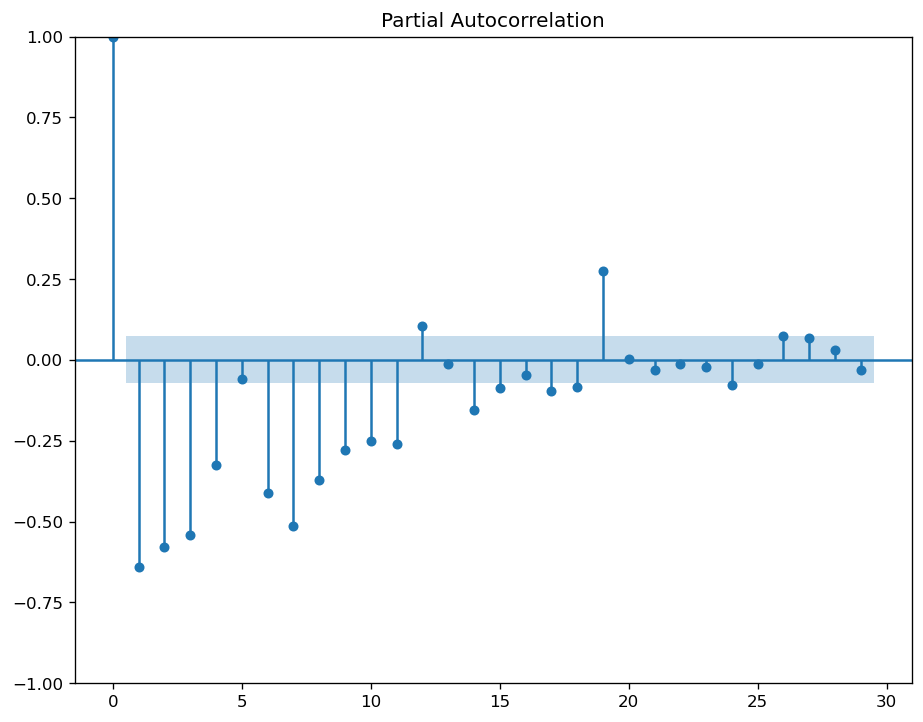

In [ ]:
#ACF
plot_acf(train1d1.Crime_Count.dropna())
#PACF
plot_pacf(train1d1.Crime_Count.dropna())

### Calculate test MSE

In [ ]:
#test MSE1

## STEP 2: Set 2 2019-2022
### Check Stationarity

Text(0, 0.5, '\nNumber of Reported Crimes\n')

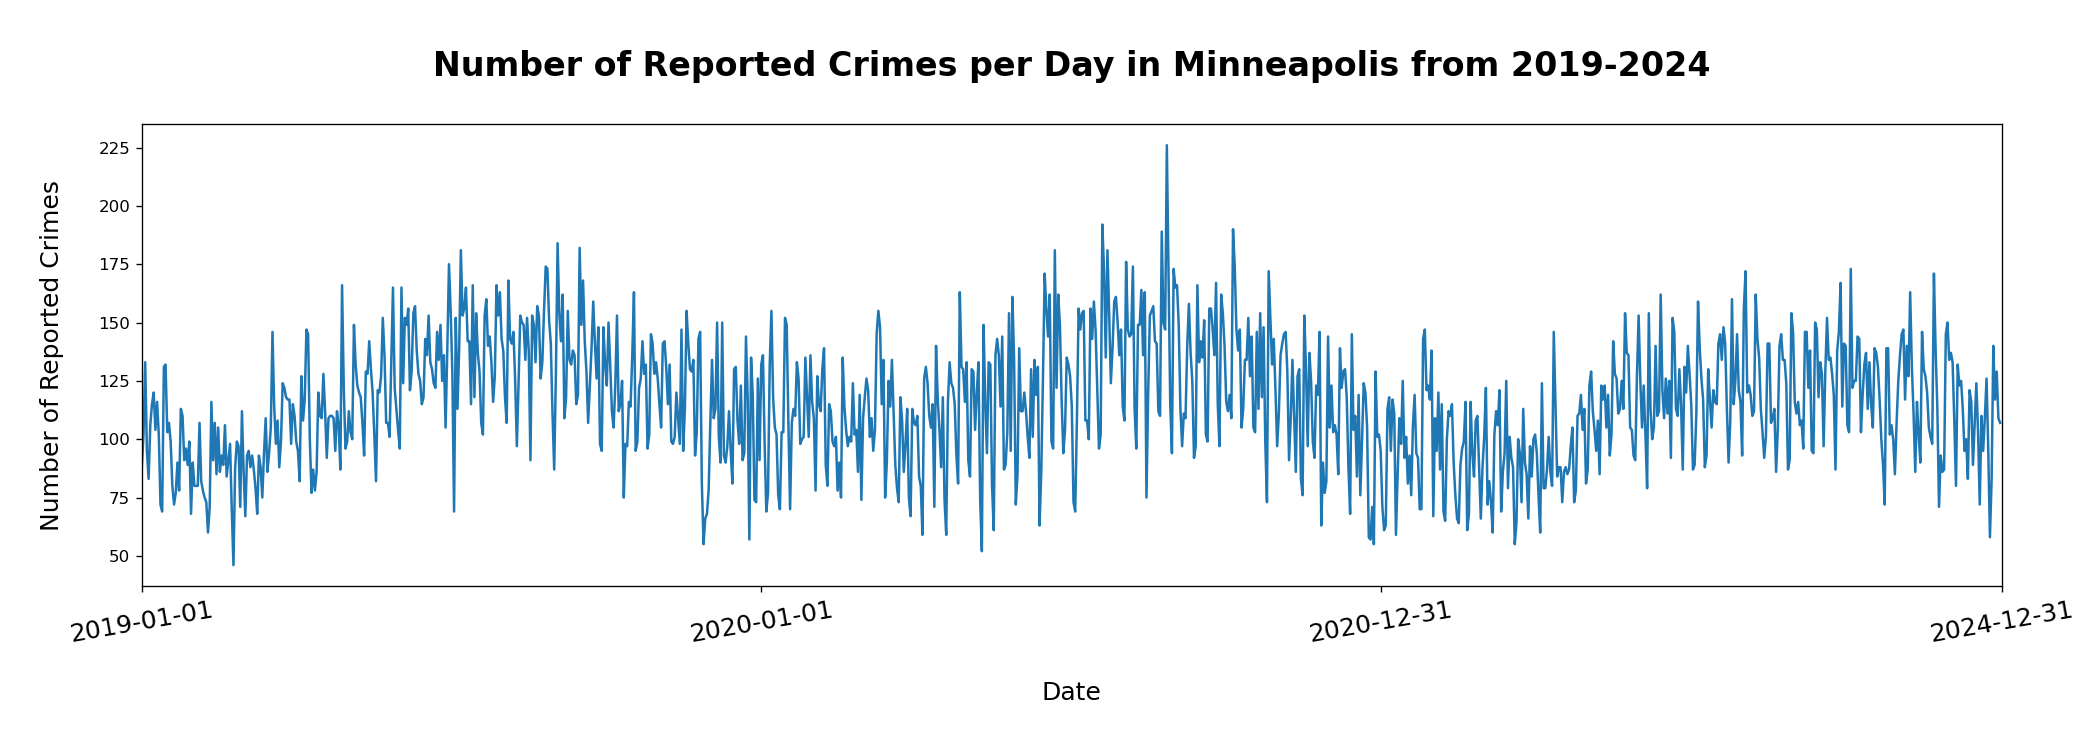

In [ ]:
#Look at plot
ax.clear()
fig, ax=plt.subplots(figsize=(20, 5))
plt.plot(train2.Crime_Count); 
plt.xticks(rotation=10, fontsize=15)

years = mdates.YearLocator()  
ax.xaxis.set_major_locator(years)

ax.set_xlim('2019-01-01', '2024-12-31')
ax.set_title("\nNumber of Reported Crimes per Day in Minneapolis from 2019-2024\n",weight='bold',fontdict={'fontsize':20})
ax.set_xlabel("\nDate\n",fontdict={'fontsize':15})
ax.set_ylabel("\nNumber of Reported Crimes\n",fontdict={'fontsize':15})



In [ ]:
#ADF Test

### Differencing

### Determine p and q

In [ ]:
#ACF
#plot_acf(train_set.Crime_Count)
#PACF
#plot_pacf(train_set.Crime_Count,lags=30)

### Calculate test MSE

## STEP 2: Set 2 2019-2023
### Check Stationarity

Text(0, 0.5, '\nNumber of Reported Crimes\n')

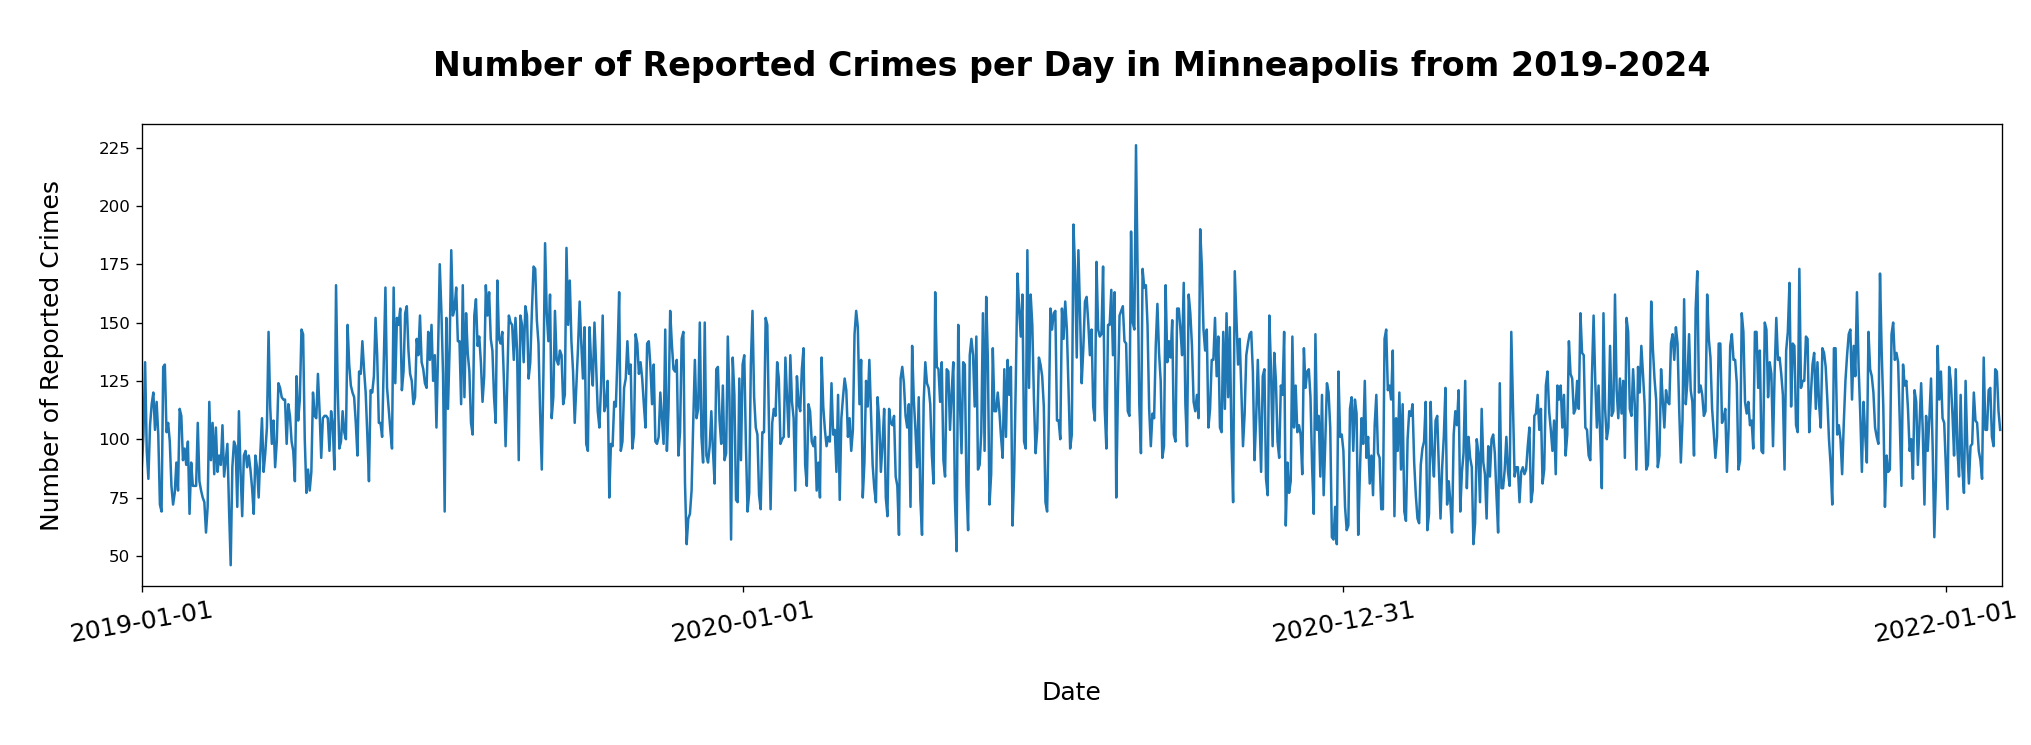

In [ ]:
#Look at plot
fig, ax=plt.subplots(figsize=(20, 5))
plt.plot(train_set.Crime_Count); 
plt.xticks(rotation=10, fontsize=15)

years = mdates.YearLocator()  
ax.xaxis.set_major_locator(years)

ax.set_xlim('2019-01-01', '2024-12-31')
ax.set_title("\nNumber of Reported Crimes per Day in Minneapolis from 2019-2024\n",weight='bold',fontdict={'fontsize':20})
ax.set_xlabel("\nDate\n",fontdict={'fontsize':15})
ax.set_ylabel("\nNumber of Reported Crimes\n",fontdict={'fontsize':15})



### Fit ARIMA Model and compare to AutoARIMA

In [ ]:
#ARIMA Model

In [ ]:
#Auto ARIMA Model

### Calculate test MSE

In [ ]:
#calculate test MSE

### K-Folds? Approach using all-subset selection

### Fit ARIMA Model and compare to AutoARIMA

In [ ]:
##AutoARIMA

#split into 6-folds
tscv = TimeSeriesSplit(n_splits=6)

# Initialize lists to store evaluation metrics
mse_scores = []

# Iterate over train-test splits and train models
for train_index, test_index in tscv.split(unidf):
    train_data, test_data = unidf.iloc[train_index], unidf.iloc[test_index]

    # Fit ARIMA model
    model = ARIMA(train_data, )  # Example order for ARIMA
    fitted_model = model.fit()

    # Make predictions
    predictions = fitted_model.forecast(steps=len(test_data))

    # Calculate Mean Squared Error
    mse = mean_squared_error(test_data, predictions)
    mse_scores.append(mse)

    print(f'Mean Squared Error for current split: {mse}')

# Calculate average Mean Squared Error across all splits
average_mse = np.mean(mse_scores)
print(f'Average Mean Squared Error across all splits: {average_mse}')

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

### Fit Best Model and Forecast

In [ ]:
#Fit Best Model

In [ ]:
#Forecast 2025

## Random Forests Time Series Regression
1. Lagged predictors
2. Check Assumptions and make corrections if needed
3. Select ARIMA Model
4. Select Best ARIMA Model
4. Interpret